In [ ]:
#поставим lablelimg
#должен быть скачан git
#https://gitforwindows.org/

import os
!pip install pyqt5 lxml
LABELIMG_PATH = os.path.join("tf", "labelimg")
if not os.path.exists(LABELIMG_PATH):
    !mkdir {LABELIMG_PATH}
    !git clone https://github.com/tzutalin/labelImg {LABELIMG_PATH}
    if os.name == 'posix':
        !make qt5py3
    if os.name =='nt':
        !cd {LABELIMG_PATH} && pyrcc5 -o libs/resources.py resources.qrc

In [ ]:
#запуск программы
!cd {LABELIMG_PATH} && python labelImg.py

In [1]:
#поработаем с XML форматом
import xml.etree.ElementTree as ET
tree = ET.parse('images/1.xml') #адрес файла
root=tree.getroot()   #анализируем
print(root)

<Element 'annotation' at 0x000002364D9421B0>


In [ ]:
#вот так ориентируемся в файле
#print(root[1].tag, root[1].text) # tag дает категорию, а text значение
#print(root[2].tag, root[2].text)
#print(root[4][0].tag, root[4][0].text)
#print(root[4][1].tag, root[4][1].text)
#print(root[7][4][0].text)

In [4]:
#сколько обьектов размечено (6 - кол-во служебных элементов, таких как размер, название и т.д)
num_objects = len(root)-6 #из всего "каталога" вычитаем всё, кроме объектов
print(num_objects)

2


In [5]:
for num in range(num_objects):
    print(root[num+6][0].tag)
    print(root[num+6][4][0].tag)

name
xmin
name
xmin


In [ ]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

In [ ]:
#преобразуем папку в tfrecord
#так чтение датасета и обучение будет быстрее

fn = "neural/images"
#формируем список всех xml файлов в папке
p = [fn + '/' + f for f in listdir(fn) if isfile(join(fn, f)) and f[-1] == 'l'] #проверяем наличие файла и его последнюю букву
#print(p)

    
def load_img(img):
    img = tf.io.read_file(img)#чтение файла
    img = tf.image.decode_jpeg(img, channels=3) #декодируем изображение в формате JPEG в тензор uint8 с тремя каналами (RGB)
    img = tf.cast(img, tf.float32)/256 #приводим тензор изображения к новому типу
    img = tf.image.resize(img,(64,64))#сжимаем изображение до размера 64*64
    return img
    
#создаем запись
writer = tf.io.TFRecordWriter('bounding_box_dataset.tfrecord')



for xml in p:
    tree = ET.parse(xml) #адрес файла
    root=tree.getroot()   #парсим
    num_objects = len(root)-6
    cords = []
    w = int(root[4][0].text) #ширина x
    h = int(root[4][1].text) #высота y
    for num in range(num_objects):
        object_cords = []
        #нормализуем координаты от -1 до 1, опираясь на исходные координаты
        object_cords.append(int(root[num+6][4][0].text)/w*2-1)
        object_cords.append(int(root[num+6][4][1].text)/h*2-1)
        object_cords.append(int(root[num+6][4][2].text)/w*2-1)
        object_cords.append(int(root[num+6][4][3].text)/h*2-1)
        cords.append(object_cords)

    img = load_img(root[2].text) #путь
    #готовим данные, представляем в байтовом виде
    serialized_img = tf.io.serialize_tensor(img).numpy() #Преобразует тензор в TensorProto proto.
    serialized_cords = tf.io.serialize_tensor(cords).numpy()
    #собираем экзепмляр
    example = tf.train.Example(features=tf.train.Features(feature={#An Example - это стандартный протокол (proto),
        #хранящий данные для обучения и вывода
        'img': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized_img])), # Feature Содержит список значений.
        'cords': tf.train.Feature(bytes_list=tf.train.BytesList(value=[serialized_cords]))# ByteList Содержит список байтовых строк
    }))

    #записываем в запись
    writer.write(example.SerializeToString())


writer.close()

In [13]:
#прочитаем запись
dataset = tf.data.TFRecordDataset('bounding_box_dataset.tfrecord')
def parse_record(record):
    #нужно описать приходящий экземпляр
    #имена элементов как при записи
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string), #Конфигурация(форма) для анализа функции ввода фиксированной длины.
        'cords': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)#Анализирует один Example прототип.
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32) #Преобразует TensorProto proto в тензор.
    cords = tf.io.parse_tensor(parsed_record['cords'], out_type=tf.float32)
    return img, cords

#пройдемся по записи и распакуем ее
dataset = dataset.map(parse_record) #функция, преобразующая элемент, возвращает tf.data - набор данных
print(dataset)

for i, c in dataset.take(5):#кортеж
    print(i.shape)
    print(c.shape)

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>
(64, 64, 3)
(2, 4)
(64, 64, 3)
(2, 4)
(64, 64, 3)
(2, 4)
(64, 64, 3)
(2, 4)
(64, 64, 3)
(2, 4)


In [10]:
import cv2
import numpy as np

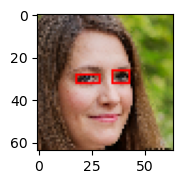

[[18 28 29 32]
 [35 26 43 32]]


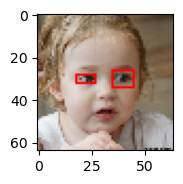

[[18 28 27 32]
 [35 26 45 34]]


In [34]:
#прочитаем запись
dataset = tf.data.TFRecordDataset('bounding_box_dataset.tfrecord')


def parse_record(record):
    #нужно описать приходящий экземпляр
    #имена элементов как при записи
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'cords': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32)
    cords = tf.io.parse_tensor(parsed_record['cords'], out_type=tf.float32)
    return img, cords

#пройдемся по записи и распакуем ее
dataset = dataset.map(parse_record)

#еще раз проверим
for i, c in dataset.take(2):
    plt.figure(figsize=(10, 6))#создание фигуры
    ax = plt.subplot(3, 1, 1)#создание рисунка и набора вложенных графиков:Количество строк / столбцов сетки вложенных графиков 
    i = i.numpy()
    c = c.numpy()
    c = (c+1)/2*64 #обратно из от -1...1 к 0...64
    c = c.astype(np.int16)  #для opencv
    for bb in c:
        i = cv2.rectangle(i ,(bb[0] ,bb[1]),(bb[2], bb[3]),(1,0,0),1)#рисуем прямоугольники: начальная точка, конечная точка, цвет, толщина
    plt.imshow(i)#отображение данных в виде изображения
    plt.show()#отображение изображения
    print(c)

dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(32).shuffle(50)# может кэшировать набор данных
#либо в памяти, либо в локальном хранилище. Это предотвратит выполнение некоторых операций (открытие файлов и чтение данных)
#в течение каждой эпохи, shuffle - перемешивает